In [36]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from matplotlib.colors import LinearSegmentedColormap

# =========================
# Palette (your colors)
# =========================
PALETTE = [
    "#b30047", "#ff4dc4", "#b30086", "#d580ff",
    "#0000e6", "#9999ff", "#85e0e0", "#009973"
]

def section(title: str):
    display(Markdown(f"---\n## {title}\n---"))

sns.set_theme(style="whitegrid")

#Load csv file.
DATA_PATH = "alzheimers_disease_data.csv"

df = pd.read_csv(DATA_PATH)
#print("Loaded df:", df.shape)
print("Columns:", df.columns.tolist())


Columns: ['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis', 'DoctorInCharge']


In [37]:

# Helpers
def to_binary(series: pd.Series):
    """Map common yes/no strings to 1/0; keeps numeric 0/1."""
    if pd.api.types.is_numeric_dtype(series):
        return pd.to_numeric(series, errors="coerce")
    s = series.astype(str).str.strip().str.lower()
    mapping = {
        "yes": 1, "y": 1, "true": 1, "1": 1,
        "no": 0, "n": 0, "false": 0, "0": 0,
        "smoker": 1, "current": 1,
        "non-smoker": 0, "nonsmoker": 0, "never": 0
    }
    return s.map(mapping)


if "Smoking" in df.columns and "Smoking_bin" not in df.columns:
    df["Smoking_bin"] = to_binary(df["Smoking"])

if "MemoryComplaints" in df.columns and "MemoryComplaints_bin" not in df.columns:
    df["MemoryComplaints_bin"] = to_binary(df["MemoryComplaints"])

if "Diagnosis" in df.columns and "Diagnosis_bin" not in df.columns:
    if pd.api.types.is_numeric_dtype(df["Diagnosis"]):
        df["Diagnosis_bin"] = pd.to_numeric(df["Diagnosis"], errors="coerce")
    else:
        s = df["Diagnosis"].astype(str).str.strip().str.lower()
        diag_map = {
            "alzheimers": 1, "alzheimer's": 1, "alzheimer": 1, "ad": 1, "1": 1, "positive": 1,
            "control": 0, "healthy": 0, "no": 0, "0": 0, "negative": 0
        }
        df["Diagnosis_bin"] = s.map(diag_map)

# Drop rows where we couldn't map diagnosis
df = df.dropna(subset=["Diagnosis_bin"]).copy()
df["Diagnosis_bin"] = df["Diagnosis_bin"].astype(int)

# Clean ints where possible
for col in ["Smoking_bin", "MemoryComplaints_bin"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df = df.dropna(subset=[col]).copy()
        df[col] = df[col].astype(int)

# Optional: numeric education level (only if EducationLevel is text)
if "EducationLevel" in df.columns:
    if not pd.api.types.is_numeric_dtype(df["EducationLevel"]):
        edu_order = {
            "none": 0, "primary": 1, "middle": 2, "highschool": 3,
            "diploma": 4, "bachelor": 5, "master": 6, "phd": 7
        }
        df["EducationLevel_num"] = (
            df["EducationLevel"].astype(str).str.strip().str.lower().map(edu_order)
        )
    else:
        df["EducationLevel_num"] = pd.to_numeric(df["EducationLevel"], errors="coerce")

print("After preprocessing:", df.shape)
print("Smoking_bin counts:\n", df["Smoking_bin"].value_counts(dropna=False) if "Smoking_bin" in df.columns else "N/A")
print("Diagnosis_bin counts:\n", df["Diagnosis_bin"].value_counts(dropna=False) if "Diagnosis_bin" in df.columns else "N/A")
print("MemoryComplaints_bin counts:\n", df["MemoryComplaints_bin"].value_counts(dropna=False) if "MemoryComplaints_bin" in df.columns else "N/A")


After preprocessing: (2149, 39)
Smoking_bin counts:
 Smoking_bin
0    1529
1     620
Name: count, dtype: int64
Diagnosis_bin counts:
 Diagnosis_bin
0    1389
1     760
Name: count, dtype: int64
MemoryComplaints_bin counts:
 MemoryComplaints_bin
0    1702
1     447
Name: count, dtype: int64


---
## 1) Smoking vs Diagnosis (Counts)
---

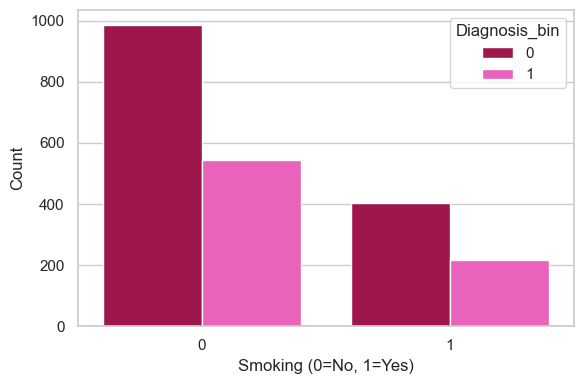

In [38]:

section("1) Smoking vs Diagnosis (Counts)")
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Smoking_bin", hue="Diagnosis_bin", palette=PALETTE[:2])
plt.xlabel("Smoking (0=No, 1=Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show(); plt.close()


---
## 2) AD Rate by Smoking (simple likelihood view)
---

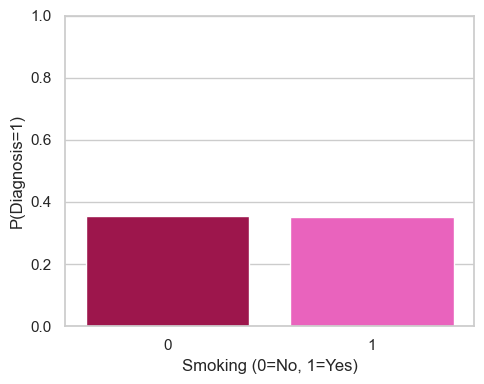

In [39]:

section("2) AD Rate by Smoking (simple likelihood view)")
rate = df.groupby("Smoking_bin")["Diagnosis_bin"].mean().reset_index()

plt.figure(figsize=(5,4))
sns.barplot(data=rate, x="Smoking_bin", y="Diagnosis_bin", hue="Smoking_bin", palette=PALETTE[:2], legend=False)
plt.xlabel("Smoking (0=No, 1=Yes)")
plt.ylabel("P(Diagnosis=1)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show(); plt.close()


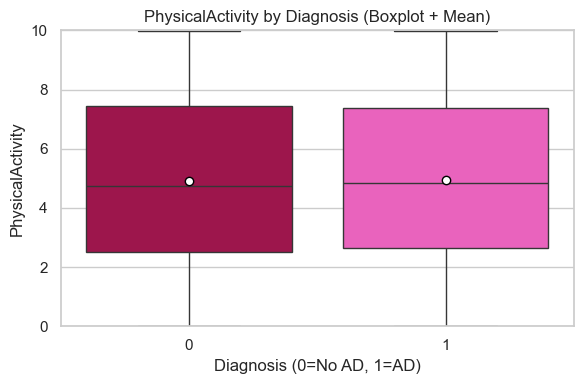

In [40]:

plt.figure(figsize=(6,4))

ax = sns.boxplot(
    data=df,
    x="Diagnosis_bin",
    y="PhysicalActivity",
    hue="Diagnosis_bin",
    palette=PALETTE[:2],
    showmeans=True,
    meanprops={"marker":"o","markerfacecolor":"white","markeredgecolor":"black","markersize":6},
    legend=False
)

ax.set_xlabel("Diagnosis (0=No AD, 1=AD)")
ax.set_ylabel("PhysicalActivity")
ax.set_ylim(0, 10)
ax.set_title("PhysicalActivity by Diagnosis (Boxplot + Mean)")
plt.tight_layout()
plt.show(); plt.close()


---
## 4) EducationLevel Distribution (multi-color)
---

C:\Users\Hanna\AppData\Local\Temp\ipykernel_17160\898530559.py:3: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.countplot(data=df, x="EducationLevel", hue="EducationLevel", palette=PALETTE, legend=False)


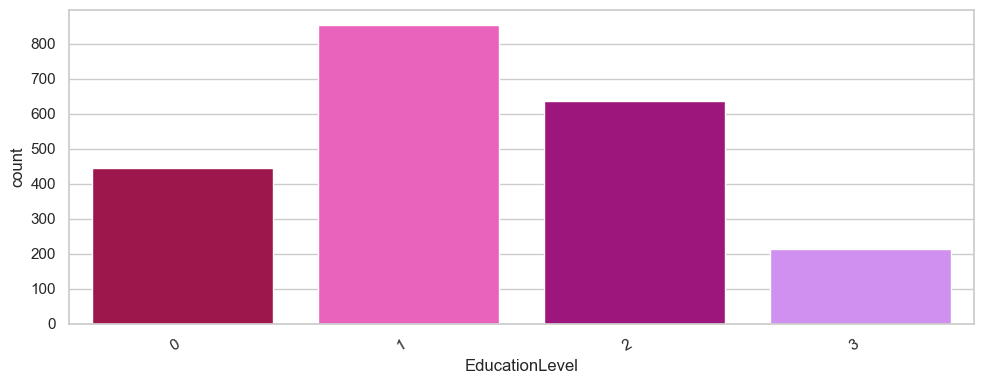

In [41]:

section("4) EducationLevel Distribution (multi-color)")
plt.figure(figsize=(10,4))
sns.countplot(data=df, x="EducationLevel", hue="EducationLevel", palette=PALETTE, legend=False)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show(); plt.close()


---
## 5) Mean MMSE by EducationLevel (multi-color)
---

C:\Users\Hanna\AppData\Local\Temp\ipykernel_17160\1862127851.py:5: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(data=mean_mmse, x="EducationLevel", y="MMSE", hue="EducationLevel", palette=PALETTE, legend=False)


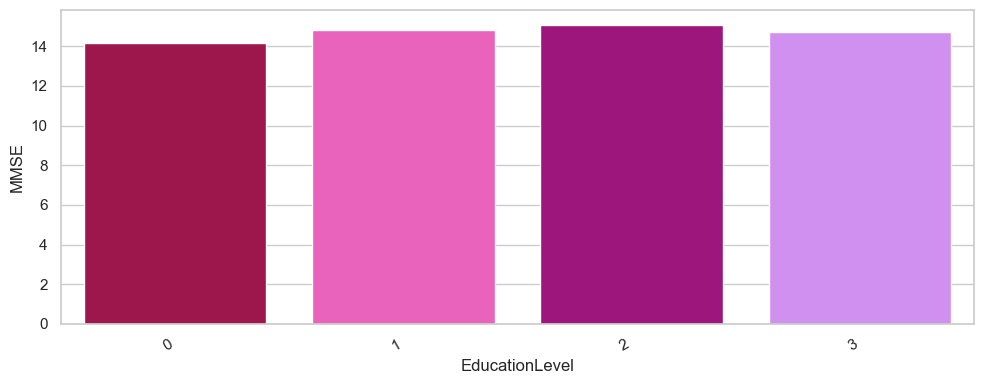

In [42]:

section("5) Mean MMSE by EducationLevel (multi-color)")
mean_mmse = df.groupby("EducationLevel", dropna=False)["MMSE"].mean().reset_index()

plt.figure(figsize=(10,4))
sns.barplot(data=mean_mmse, x="EducationLevel", y="MMSE", hue="EducationLevel", palette=PALETTE, legend=False)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show(); plt.close()


---
## 7) SleepQuality by MemoryComplaints (Boxplot)
---

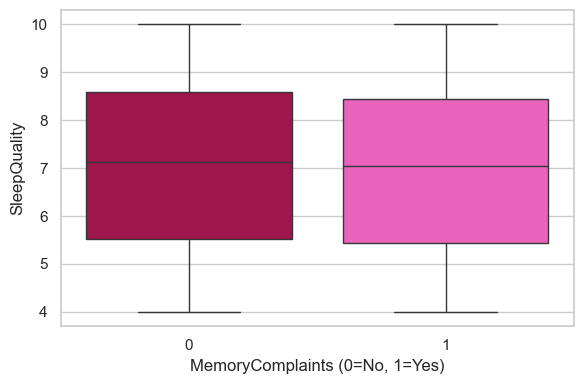

In [43]:

section("7) SleepQuality by MemoryComplaints (Boxplot)")
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="MemoryComplaints_bin", y="SleepQuality", hue="MemoryComplaints_bin", palette=PALETTE[:2], legend=False)
plt.xlabel("MemoryComplaints (0=No, 1=Yes)")
plt.tight_layout()
plt.show(); plt.close()
